# 1 数据分析
## 1.1 数据加载和概览
1. train.csv中有1017209行数据，9个数据维度，其中Sales是测试集中需要预测的列。
在9个数据维度中，没有缺失值，其中Date和StateHoliday是非数值格式，后面根据需要进行处理，其他都为数值型格式。

2. store.csv中有1115行数据，10个数据维度，多个数据维度都有缺失，需要后续考虑补全缺失值，其中StoreType、Assortment、PromoInterval是非数值格式，后续根据需要进行处理，其他都为数值型格式。
train.csv和store.csv中有相同的键值Store，且Store的去重后数量也相同，后续根据需要把两个表合并。

3. test.csv中有41088行数据，8个数据维度，其中和train.csv相比，缺少Sales列和Customers列数据，Sales是模型的预测值，Customers缺失的话，在训练时不能作为特征维度，需要后面去除该列。test.csv中和train.csv中部分维度数据格式不同，后续根据实际情况考虑是否需要统一格式。

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
store = pd.read_csv("store.csv")
train = pd.read_csv("train.csv", parse_dates=[2])
test = pd.read_csv("test.csv", parse_dates=[3])

/Users/wj/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
store['Store'].unique().size

1115

In [5]:
store.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [6]:
train.head().append(train.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [7]:
train.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [8]:
train['Store'].unique().size

1115

In [9]:
np.sum([train['Sales'] == 0])

172871

In [10]:
#分别探索store1和10的销售额时间分布
import matplotlib.pyplot as plt
store_1 = train.loc[(train["Store"]==1)&(train['Sales']>0), ['Date',"Sales"]]
store_10 = train.loc[(train["Store"]==10)&(train['Sales']>0), ['Date',"Sales"]]
f = plt.figure(figsize=(18,10))
ax1 = f.add_subplot(211)
ax1.plot(store_1['Date'], store_1['Sales'], '-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Sales')
ax1.set_title('Store 1 Sales Distribution')

ax2 = f.add_subplot(212)
ax2.plot(store_10['Date'], store_10['Sales'], '-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Sales')
ax2.set_title('Store 10 Sales Distribution')

Text(0.5,1,'Store 10 Sales Distribution')

In [11]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [12]:
test.shape

(41088, 8)

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


## 1.2 非数值型数据数据的分布情况
1. train.csv中Date时间范围是从2013年1月到2015年7月，后续将Date分割为年、月、日的数值型数据；test.csv中需要预测的Date时间范围是从2015年8月1日到9月17日；

2. PromoInterval是有三类： Jan,Apr,Jul,Oct；  Feb,May,Aug,Nov； Mar,Jun,Sept,Dec；后续将三个分类转化为12列数值型数据，即1-12月是否有营销活动。

3. StateHoliday字段应该有4个分类，统计结果显示5个，需要对两个0进行合并。

4. 其他非数值型的字段后续根据需要通过one-hot编码转化为数值型数据。

In [14]:
train['Date'].unique()

array(['2015-07-31T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
       '2015-07-29T00:00:00.000000000', '2015-07-28T00:00:00.000000000',
       '2015-07-27T00:00:00.000000000', '2015-07-26T00:00:00.000000000',
       '2015-07-25T00:00:00.000000000', '2015-07-24T00:00:00.000000000',
       '2015-07-23T00:00:00.000000000', '2015-07-22T00:00:00.000000000',
       '2015-07-21T00:00:00.000000000', '2015-07-20T00:00:00.000000000',
       '2015-07-19T00:00:00.000000000', '2015-07-18T00:00:00.000000000',
       '2015-07-17T00:00:00.000000000', '2015-07-16T00:00:00.000000000',
       '2015-07-15T00:00:00.000000000', '2015-07-14T00:00:00.000000000',
       '2015-07-13T00:00:00.000000000', '2015-07-12T00:00:00.000000000',
       '2015-07-11T00:00:00.000000000', '2015-07-10T00:00:00.000000000',
       '2015-07-09T00:00:00.000000000', '2015-07-08T00:00:00.000000000',
       '2015-07-07T00:00:00.000000000', '2015-07-06T00:00:00.000000000',
       '2015-07-05T00:00:00.000000000', '2015-07-04

In [15]:
test['Date'].unique()

array(['2015-09-17T00:00:00.000000000', '2015-09-16T00:00:00.000000000',
       '2015-09-15T00:00:00.000000000', '2015-09-14T00:00:00.000000000',
       '2015-09-13T00:00:00.000000000', '2015-09-12T00:00:00.000000000',
       '2015-09-11T00:00:00.000000000', '2015-09-10T00:00:00.000000000',
       '2015-09-09T00:00:00.000000000', '2015-09-08T00:00:00.000000000',
       '2015-09-07T00:00:00.000000000', '2015-09-06T00:00:00.000000000',
       '2015-09-05T00:00:00.000000000', '2015-09-04T00:00:00.000000000',
       '2015-09-03T00:00:00.000000000', '2015-09-02T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-08-30T00:00:00.000000000', '2015-08-29T00:00:00.000000000',
       '2015-08-28T00:00:00.000000000', '2015-08-27T00:00:00.000000000',
       '2015-08-26T00:00:00.000000000', '2015-08-25T00:00:00.000000000',
       '2015-08-24T00:00:00.000000000', '2015-08-23T00:00:00.000000000',
       '2015-08-22T00:00:00.000000000', '2015-08-21

In [16]:
pd.value_counts(train['StateHoliday'])

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [17]:
pd.value_counts(store['StoreType'])

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [18]:
pd.value_counts(store['Assortment'])

a    593
c    513
b      9
Name: Assortment, dtype: int64

In [19]:
pd.value_counts(store['PromoInterval'])

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

## 1.3 数值型数据的分布情况
1. CompetitionDistance数值分布非正态，中位数和均值相差较大，后续根据需要进行特征缩放；

In [20]:
pd.value_counts(train['DayOfWeek'])

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

In [21]:
pd.value_counts(train['Open'])

1    844392
0    172817
Name: Open, dtype: int64

In [22]:
pd.value_counts(train['Promo'])

0    629129
1    388080
Name: Promo, dtype: int64

In [70]:
import seaborn as sns
sns.set_style('darkgrid') 
train['Customers'].plot(kind='hist',bins=35,color='darkseagreen',figsize=[8,6])
plt.title('Customers')

KeyError: 'Customers'

In [ ]:
train['Customers'].describe()

In [ ]:
train['Sales'].plot(kind='hist',bins=35,color='darkseagreen',figsize=[8,6])
plt.title('Sales')

In [24]:
train['Sales'].describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

Text(0.5,1,'CompetitionDistance')

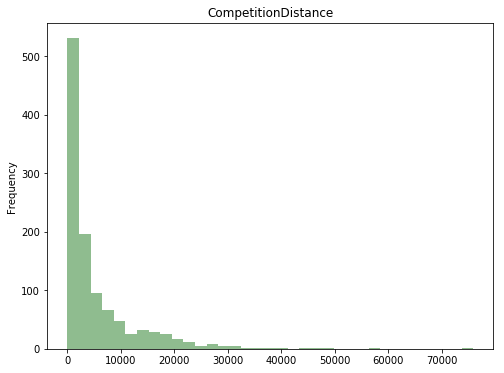

In [25]:
store['CompetitionDistance'].plot(kind='hist',bins=35,color='darkseagreen',figsize=[8,6])
plt.title('CompetitionDistance')

In [26]:
store['CompetitionDistance'].describe()

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

In [27]:
pd.value_counts(store['CompetitionOpenSinceMonth'])

9.0     125
4.0      94
11.0     92
3.0      70
7.0      67
12.0     64
10.0     61
6.0      50
5.0      44
2.0      41
8.0      39
1.0      14
Name: CompetitionOpenSinceMonth, dtype: int64

In [28]:
pd.value_counts(store['Promo2'])

1    571
0    544
Name: Promo2, dtype: int64

# 2 数据预处理
## 2.1 数据合并和筛选

In [29]:
#检查各个特征空值数
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [30]:
store.fillna(0, inplace=True)

In [31]:
#train集没有发现空数据
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [32]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Text(0.5,1,'Store Daily Open CountPlot')

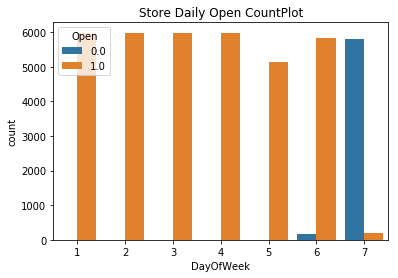

In [33]:
#探索商店在周一到周末的开业情况
import seaborn as sns
sns.countplot(x = 'DayOfWeek', hue = 'Open', data = test)
plt.title('Store Daily Open CountPlot')

In [34]:
#探索test集中Open为空的数据
test[test.Open.isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [35]:
#空值以1代替
test.fillna(value = 1, inplace = True)

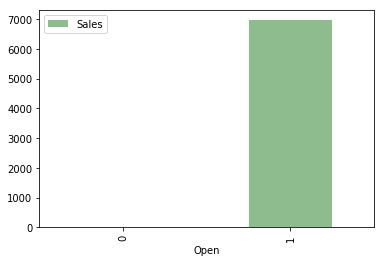

In [36]:
#数据筛选，发现open为0时，销量一定为0,因此可以在训练时先把open为0的数据删除
pd.pivot_table(train,values=['Sales'],index=['Open'],aggfunc=np.mean).plot(kind='bar',color='darkseagreen')

In [37]:
#合并train和Store数据集，test和Store数据集
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

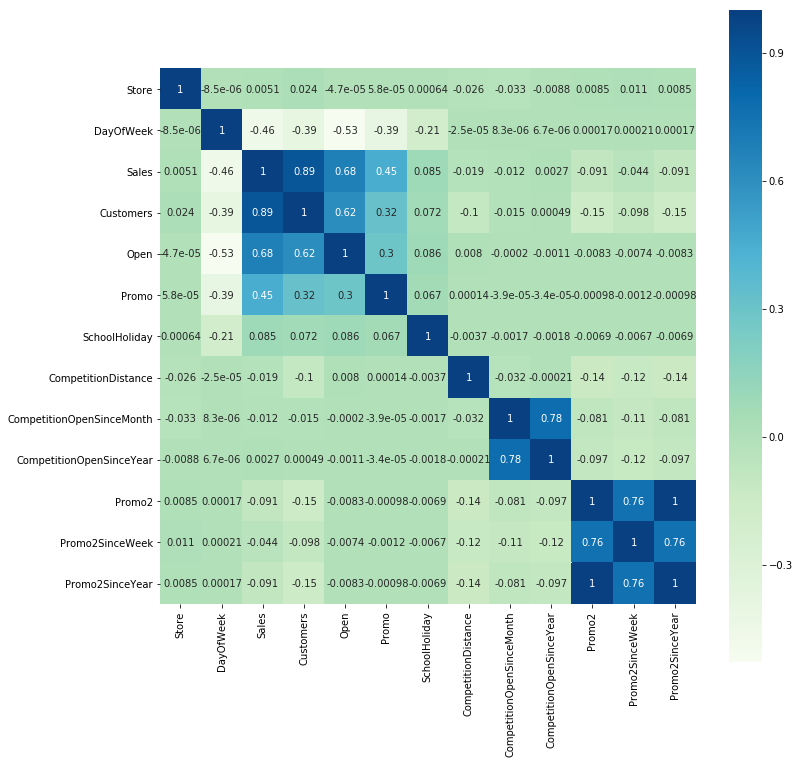

In [38]:
#简单查看特征间相关性和影响Sales的主要特征
import seaborn as sns
import matplotlib.pyplot as plt
corr1 = train.corr()
plt.subplots(figsize = (12, 12))
sns.heatmap(corr1, annot=True, vmax=1, square=True,cmap='GnBu')
plt.show()

In [39]:
#把最后4周的数据集作为验证数据集
train = train.sort_values(['Date'], ascending=False)
train_total = train.copy()

split_index = 4*7*1115
valid = train[:split_index]
train = train[split_index:]

#过滤掉没有开门和销售额小于等于0的数据
valid = valid[(valid.Open !=0)&(valid.Sales > 0)]
train = train[(train.Open !=0)&(train.Sales > 0)]
train_total = train_total[(train_total.Open !=0)&(train_total.Sales > 0)]

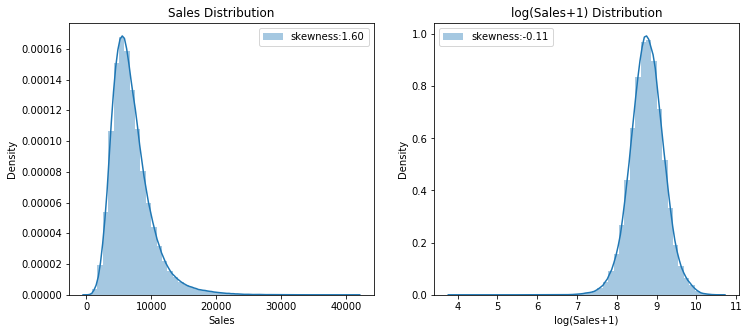

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

#探索train集上的销售额分布
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Sales', ylabel = 'Density', title = 'Sales Distribution')
g2 = sns.distplot(np.log1p(train['Sales']),hist = True,label='skewness:{:.2f}'.format(np.log1p(train['Sales']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Sales+1)',ylabel = 'Density', title = 'log(Sales+1) Distribution')
plt.show()

In [41]:
#处理train和test集
def process(data, isTest = False):
    #标签编码
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #根据已有特征提取额外特征 
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    #计算竞争者开门的月
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
    #计算月中的promo2
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
                                                 
    #当前月是否在促销期间
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month2str)

    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)    
    
    #选择需要的特征
    features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']  
    if not isTest:
        features.append('Sales')
        
    data = data[features]
    return data

train = process(train)
valid = process(valid)
train_total = process(train_total)
x_test = process(test,isTest = True)  

In [42]:
valid.sort_index(inplace = True)
train.sort_index(inplace = True)
train_total.sort_index(inplace = True)

#训练集和验证集分裂成X和y
x_train, y_train = train.drop(columns = ['Sales']), np.log1p(train['Sales'])
x_valid, y_valid = valid.drop(columns = ['Sales']), np.log1p(valid['Sales'])
x_train_total, y_train_total = train_total.drop(columns = ['Sales']), np.log1p(train_total['Sales'])

In [43]:
#定义评估函数
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

## 2.2 基准模型

In [68]:
#随机森林
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators = 15)
clf.fit(x_train, y_train)
#验证
y_pred = clf.predict(x_valid)
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.1607


Text(0.5,1,'Feature Importance')

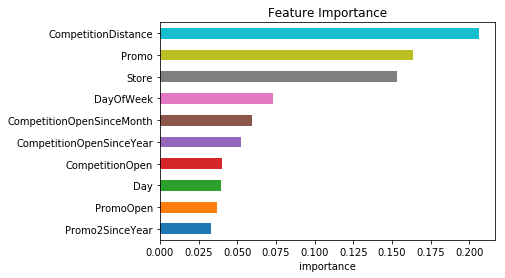

In [69]:
#画出随机森林中Top10重要的特征
feat_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')
plt.xlabel('importance')
plt.title('Feature Importance')

## 2.3 XGB模型

In [46]:
import xgboost as xgb

params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.03,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 10   # Random number seed
          }
num_boost_round = 4000

dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
#训练xgb模型
model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:8.02094	eval-rmse:8.02661	train-rmspe:0.999809	eval-rmspe:0.999812
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78082	eval-rmse:7.78671	train-rmspe:0.999711	eval-rmspe:0.999715
[2]	train-rmse:7.54789	eval-rmse:7.55384	train-rmspe:0.99959	eval-rmspe:0.999596
[3]	train-rmse:7.32202	eval-rmse:7.32827	train-rmspe:0.999444	eval-rmspe:0.999452
[4]	train-rmse:7.1029	eval-rmse:7.10867	train-rmspe:0.999266	eval-rmspe:0.999276
[5]	train-rmse:6.8903	eval-rmse:6.8961	train-rmspe:0.999054	eval-rmspe:0.999067
[6]	train-rmse:6.68418	eval-rmse:6.68934	train-rmspe:0.998799	eval-rmspe:0.998814
[7]	train-rmse:6.48416	eval-rmse:6.48935	train-rmspe:0.998498	eval-rmspe:0.998517
[8]	train-rmse:6.29019	eval-rmse:6.29543	train-rmspe:0.998142	eval-rmspe:0.998165
[9]	train-rmse:6.10211	eval-rmse:6.10712	train-rmspe:0.997723	eval-rmspe:0.997751
[10]	train-rmse:5.91961	eval-rmse:5.92

[98]	train-rmse:0.476499	eval-rmse:0.483181	train-rmspe:0.372449	eval-rmspe:0.364204
[99]	train-rmse:0.465943	eval-rmse:0.472875	train-rmspe:0.366706	eval-rmspe:0.35811
[100]	train-rmse:0.455828	eval-rmse:0.463015	train-rmspe:0.361239	eval-rmspe:0.352268
[101]	train-rmse:0.445953	eval-rmse:0.453032	train-rmspe:0.355874	eval-rmspe:0.346349
[102]	train-rmse:0.436635	eval-rmse:0.443987	train-rmspe:0.350697	eval-rmspe:0.340936
[103]	train-rmse:0.427249	eval-rmse:0.434622	train-rmspe:0.345614	eval-rmspe:0.335359
[104]	train-rmse:0.418438	eval-rmse:0.425617	train-rmspe:0.34088	eval-rmspe:0.329965
[105]	train-rmse:0.410021	eval-rmse:0.417396	train-rmspe:0.336378	eval-rmspe:0.325028
[106]	train-rmse:0.40197	eval-rmse:0.409486	train-rmspe:0.332023	eval-rmspe:0.320291
[107]	train-rmse:0.394221	eval-rmse:0.401963	train-rmspe:0.327842	eval-rmspe:0.315801
[108]	train-rmse:0.386802	eval-rmse:0.394759	train-rmspe:0.32407	eval-rmspe:0.311513
[109]	train-rmse:0.378807	eval-rmse:0.386776	train-rmspe:0.3

[194]	train-rmse:0.192766	eval-rmse:0.202595	train-rmspe:0.240444	eval-rmspe:0.208769
[195]	train-rmse:0.192056	eval-rmse:0.201925	train-rmspe:0.240033	eval-rmspe:0.208334
[196]	train-rmse:0.191303	eval-rmse:0.201203	train-rmspe:0.239541	eval-rmspe:0.207803
[197]	train-rmse:0.191019	eval-rmse:0.200933	train-rmspe:0.239426	eval-rmspe:0.207702
[198]	train-rmse:0.190439	eval-rmse:0.200471	train-rmspe:0.239132	eval-rmspe:0.207392
[199]	train-rmse:0.190223	eval-rmse:0.200258	train-rmspe:0.23914	eval-rmspe:0.207362
[200]	train-rmse:0.189415	eval-rmse:0.199571	train-rmspe:0.238555	eval-rmspe:0.206862
[201]	train-rmse:0.188683	eval-rmse:0.198847	train-rmspe:0.238104	eval-rmspe:0.206302
[202]	train-rmse:0.188238	eval-rmse:0.198448	train-rmspe:0.237908	eval-rmspe:0.206101
[203]	train-rmse:0.187979	eval-rmse:0.198191	train-rmspe:0.237795	eval-rmspe:0.205948
[204]	train-rmse:0.187719	eval-rmse:0.19802	train-rmspe:0.237715	eval-rmspe:0.205881
[205]	train-rmse:0.187532	eval-rmse:0.197866	train-rmspe

[290]	train-rmse:0.155614	eval-rmse:0.168424	train-rmspe:0.196687	eval-rmspe:0.178719
[291]	train-rmse:0.155444	eval-rmse:0.168282	train-rmspe:0.196526	eval-rmspe:0.178593
[292]	train-rmse:0.155323	eval-rmse:0.16814	train-rmspe:0.196375	eval-rmspe:0.178373
[293]	train-rmse:0.154861	eval-rmse:0.167739	train-rmspe:0.195969	eval-rmspe:0.177965
[294]	train-rmse:0.154603	eval-rmse:0.16754	train-rmspe:0.195725	eval-rmspe:0.177743
[295]	train-rmse:0.154326	eval-rmse:0.167288	train-rmspe:0.195468	eval-rmspe:0.177476
[296]	train-rmse:0.154045	eval-rmse:0.166994	train-rmspe:0.195219	eval-rmspe:0.177156
[297]	train-rmse:0.153935	eval-rmse:0.166903	train-rmspe:0.195129	eval-rmspe:0.177065
[298]	train-rmse:0.153738	eval-rmse:0.166715	train-rmspe:0.194227	eval-rmspe:0.176872
[299]	train-rmse:0.153444	eval-rmse:0.166429	train-rmspe:0.19398	eval-rmspe:0.176547
[300]	train-rmse:0.153188	eval-rmse:0.16623	train-rmspe:0.193536	eval-rmspe:0.176333
[301]	train-rmse:0.152953	eval-rmse:0.166054	train-rmspe:0

[386]	train-rmse:0.134222	eval-rmse:0.150177	train-rmspe:0.167822	eval-rmspe:0.15918
[387]	train-rmse:0.134177	eval-rmse:0.150122	train-rmspe:0.167764	eval-rmspe:0.159135
[388]	train-rmse:0.134145	eval-rmse:0.15009	train-rmspe:0.167543	eval-rmspe:0.159099
[389]	train-rmse:0.133655	eval-rmse:0.149675	train-rmspe:0.16708	eval-rmspe:0.158612
[390]	train-rmse:0.133392	eval-rmse:0.149423	train-rmspe:0.166773	eval-rmspe:0.158324
[391]	train-rmse:0.133258	eval-rmse:0.14939	train-rmspe:0.166567	eval-rmspe:0.158278
[392]	train-rmse:0.133195	eval-rmse:0.149305	train-rmspe:0.166502	eval-rmspe:0.158223
[393]	train-rmse:0.133052	eval-rmse:0.149174	train-rmspe:0.166363	eval-rmspe:0.158068
[394]	train-rmse:0.132917	eval-rmse:0.149059	train-rmspe:0.16617	eval-rmspe:0.157961
[395]	train-rmse:0.132599	eval-rmse:0.148794	train-rmspe:0.165865	eval-rmspe:0.157677
[396]	train-rmse:0.132464	eval-rmse:0.148646	train-rmspe:0.165748	eval-rmspe:0.157514
[397]	train-rmse:0.132394	eval-rmse:0.148651	train-rmspe:0.

[482]	train-rmse:0.119579	eval-rmse:0.138675	train-rmspe:0.148236	eval-rmspe:0.146445
[483]	train-rmse:0.119557	eval-rmse:0.138657	train-rmspe:0.148186	eval-rmspe:0.146425
[484]	train-rmse:0.119486	eval-rmse:0.138589	train-rmspe:0.148112	eval-rmspe:0.146358
[485]	train-rmse:0.119406	eval-rmse:0.138546	train-rmspe:0.148035	eval-rmspe:0.146311
[486]	train-rmse:0.119159	eval-rmse:0.138349	train-rmspe:0.147801	eval-rmspe:0.146102
[487]	train-rmse:0.118997	eval-rmse:0.138156	train-rmspe:0.147656	eval-rmspe:0.145894
[488]	train-rmse:0.118773	eval-rmse:0.137968	train-rmspe:0.147438	eval-rmspe:0.145723
[489]	train-rmse:0.118712	eval-rmse:0.13791	train-rmspe:0.147374	eval-rmspe:0.145653
[490]	train-rmse:0.118606	eval-rmse:0.137834	train-rmspe:0.147256	eval-rmspe:0.145574
[491]	train-rmse:0.118526	eval-rmse:0.137738	train-rmspe:0.147172	eval-rmspe:0.145452
[492]	train-rmse:0.118349	eval-rmse:0.137645	train-rmspe:0.146956	eval-rmspe:0.145327
[493]	train-rmse:0.11828	eval-rmse:0.137612	train-rmspe

[578]	train-rmse:0.110862	eval-rmse:0.13263	train-rmspe:0.136804	eval-rmspe:0.140117
[579]	train-rmse:0.110751	eval-rmse:0.132524	train-rmspe:0.136614	eval-rmspe:0.140006
[580]	train-rmse:0.110644	eval-rmse:0.132449	train-rmspe:0.136521	eval-rmspe:0.139915
[581]	train-rmse:0.110576	eval-rmse:0.132387	train-rmspe:0.136459	eval-rmspe:0.139848
[582]	train-rmse:0.110527	eval-rmse:0.13236	train-rmspe:0.136406	eval-rmspe:0.13982
[583]	train-rmse:0.110506	eval-rmse:0.132348	train-rmspe:0.136387	eval-rmspe:0.139808
[584]	train-rmse:0.110462	eval-rmse:0.132311	train-rmspe:0.13628	eval-rmspe:0.139772
[585]	train-rmse:0.110436	eval-rmse:0.132289	train-rmspe:0.136249	eval-rmspe:0.139748
[586]	train-rmse:0.110362	eval-rmse:0.132198	train-rmspe:0.13618	eval-rmspe:0.139663
[587]	train-rmse:0.110294	eval-rmse:0.132156	train-rmspe:0.136119	eval-rmspe:0.139613
[588]	train-rmse:0.110254	eval-rmse:0.132127	train-rmspe:0.136078	eval-rmspe:0.139583
[589]	train-rmse:0.110177	eval-rmse:0.132038	train-rmspe:0.

[674]	train-rmse:0.10396	eval-rmse:0.128224	train-rmspe:0.127533	eval-rmspe:0.135402
[675]	train-rmse:0.103886	eval-rmse:0.128175	train-rmspe:0.127457	eval-rmspe:0.135356
[676]	train-rmse:0.103861	eval-rmse:0.128199	train-rmspe:0.127416	eval-rmspe:0.135399
[677]	train-rmse:0.103827	eval-rmse:0.128168	train-rmspe:0.127382	eval-rmspe:0.135365
[678]	train-rmse:0.103769	eval-rmse:0.128117	train-rmspe:0.127327	eval-rmspe:0.1353
[679]	train-rmse:0.103736	eval-rmse:0.128086	train-rmspe:0.127289	eval-rmspe:0.13527
[680]	train-rmse:0.103684	eval-rmse:0.128056	train-rmspe:0.12724	eval-rmspe:0.13524
[681]	train-rmse:0.103614	eval-rmse:0.128014	train-rmspe:0.127165	eval-rmspe:0.1352
[682]	train-rmse:0.103574	eval-rmse:0.127985	train-rmspe:0.127121	eval-rmspe:0.135169
[683]	train-rmse:0.103545	eval-rmse:0.127978	train-rmspe:0.12709	eval-rmspe:0.135174
[684]	train-rmse:0.103485	eval-rmse:0.127937	train-rmspe:0.127027	eval-rmspe:0.135128
[685]	train-rmse:0.103428	eval-rmse:0.127903	train-rmspe:0.1263

[770]	train-rmse:0.099259	eval-rmse:0.125122	train-rmspe:0.119808	eval-rmspe:0.13221
[771]	train-rmse:0.099196	eval-rmse:0.125084	train-rmspe:0.119752	eval-rmspe:0.132164
[772]	train-rmse:0.099144	eval-rmse:0.125045	train-rmspe:0.1197	eval-rmspe:0.132136
[773]	train-rmse:0.09911	eval-rmse:0.125034	train-rmspe:0.119663	eval-rmspe:0.132125
[774]	train-rmse:0.09909	eval-rmse:0.124987	train-rmspe:0.119631	eval-rmspe:0.132081
[775]	train-rmse:0.099078	eval-rmse:0.124958	train-rmspe:0.11962	eval-rmspe:0.132066
[776]	train-rmse:0.099062	eval-rmse:0.124927	train-rmspe:0.119591	eval-rmspe:0.132034
[777]	train-rmse:0.098998	eval-rmse:0.124894	train-rmspe:0.119532	eval-rmspe:0.131999
[778]	train-rmse:0.098948	eval-rmse:0.124875	train-rmspe:0.11948	eval-rmspe:0.131976
[779]	train-rmse:0.098846	eval-rmse:0.124799	train-rmspe:0.119381	eval-rmspe:0.131889
[780]	train-rmse:0.098806	eval-rmse:0.124772	train-rmspe:0.119339	eval-rmspe:0.131863
[781]	train-rmse:0.098784	eval-rmse:0.124758	train-rmspe:0.11

[866]	train-rmse:0.095536	eval-rmse:0.122952	train-rmspe:0.11502	eval-rmspe:0.129864
[867]	train-rmse:0.095484	eval-rmse:0.12303	train-rmspe:0.11495	eval-rmspe:0.129997
[868]	train-rmse:0.095424	eval-rmse:0.122991	train-rmspe:0.114891	eval-rmspe:0.129958
[869]	train-rmse:0.095381	eval-rmse:0.122948	train-rmspe:0.114833	eval-rmspe:0.129924
[870]	train-rmse:0.095361	eval-rmse:0.122953	train-rmspe:0.114811	eval-rmspe:0.129915
[871]	train-rmse:0.095307	eval-rmse:0.122923	train-rmspe:0.114761	eval-rmspe:0.129887
[872]	train-rmse:0.095294	eval-rmse:0.122912	train-rmspe:0.114076	eval-rmspe:0.12988
[873]	train-rmse:0.095248	eval-rmse:0.122888	train-rmspe:0.11403	eval-rmspe:0.12985
[874]	train-rmse:0.095217	eval-rmse:0.122871	train-rmspe:0.113988	eval-rmspe:0.129833
[875]	train-rmse:0.095201	eval-rmse:0.12286	train-rmspe:0.113969	eval-rmspe:0.129816
[876]	train-rmse:0.095176	eval-rmse:0.122854	train-rmspe:0.113947	eval-rmspe:0.129816
[877]	train-rmse:0.095138	eval-rmse:0.122828	train-rmspe:0.11

[962]	train-rmse:0.09227	eval-rmse:0.121579	train-rmspe:0.109662	eval-rmspe:0.128568
[963]	train-rmse:0.092241	eval-rmse:0.121571	train-rmspe:0.109635	eval-rmspe:0.128564
[964]	train-rmse:0.092193	eval-rmse:0.121541	train-rmspe:0.109586	eval-rmspe:0.128531
[965]	train-rmse:0.092165	eval-rmse:0.121515	train-rmspe:0.109559	eval-rmspe:0.1285
[966]	train-rmse:0.092128	eval-rmse:0.121493	train-rmspe:0.109524	eval-rmspe:0.128473
[967]	train-rmse:0.092117	eval-rmse:0.121456	train-rmspe:0.109513	eval-rmspe:0.128447
[968]	train-rmse:0.092089	eval-rmse:0.121445	train-rmspe:0.109483	eval-rmspe:0.128434
[969]	train-rmse:0.092042	eval-rmse:0.121421	train-rmspe:0.109435	eval-rmspe:0.128406
[970]	train-rmse:0.092018	eval-rmse:0.121398	train-rmspe:0.109408	eval-rmspe:0.128384
[971]	train-rmse:0.091989	eval-rmse:0.121385	train-rmspe:0.109379	eval-rmspe:0.128367
[972]	train-rmse:0.091954	eval-rmse:0.12137	train-rmspe:0.109343	eval-rmspe:0.128355
[973]	train-rmse:0.091932	eval-rmse:0.121353	train-rmspe:0

[1058]	train-rmse:0.089668	eval-rmse:0.120422	train-rmspe:0.106361	eval-rmspe:0.127549
[1059]	train-rmse:0.089656	eval-rmse:0.120405	train-rmspe:0.106348	eval-rmspe:0.127536
[1060]	train-rmse:0.089638	eval-rmse:0.120421	train-rmspe:0.10632	eval-rmspe:0.127537
[1061]	train-rmse:0.089617	eval-rmse:0.120418	train-rmspe:0.106298	eval-rmspe:0.127534
[1062]	train-rmse:0.089593	eval-rmse:0.120415	train-rmspe:0.106273	eval-rmspe:0.127527
[1063]	train-rmse:0.08958	eval-rmse:0.120411	train-rmspe:0.106261	eval-rmspe:0.12752
[1064]	train-rmse:0.089564	eval-rmse:0.120407	train-rmspe:0.106243	eval-rmspe:0.127516
[1065]	train-rmse:0.089552	eval-rmse:0.1204	train-rmspe:0.106231	eval-rmspe:0.127511
[1066]	train-rmse:0.089523	eval-rmse:0.12039	train-rmspe:0.106196	eval-rmspe:0.127501
[1067]	train-rmse:0.089517	eval-rmse:0.120387	train-rmspe:0.106189	eval-rmspe:0.127497
[1068]	train-rmse:0.089498	eval-rmse:0.120382	train-rmspe:0.106171	eval-rmspe:0.127492
[1069]	train-rmse:0.089464	eval-rmse:0.120369	tra

[1153]	train-rmse:0.087551	eval-rmse:0.119665	train-rmspe:0.103077	eval-rmspe:0.126712
[1154]	train-rmse:0.087529	eval-rmse:0.119655	train-rmspe:0.103054	eval-rmspe:0.126701
[1155]	train-rmse:0.087508	eval-rmse:0.119639	train-rmspe:0.103036	eval-rmspe:0.12669
[1156]	train-rmse:0.087474	eval-rmse:0.119622	train-rmspe:0.103002	eval-rmspe:0.12667
[1157]	train-rmse:0.087458	eval-rmse:0.119599	train-rmspe:0.102987	eval-rmspe:0.126659
[1158]	train-rmse:0.087434	eval-rmse:0.119586	train-rmspe:0.102963	eval-rmspe:0.126643
[1159]	train-rmse:0.087406	eval-rmse:0.119574	train-rmspe:0.102929	eval-rmspe:0.126631
[1160]	train-rmse:0.087378	eval-rmse:0.119555	train-rmspe:0.102901	eval-rmspe:0.126623
[1161]	train-rmse:0.087351	eval-rmse:0.119518	train-rmspe:0.102868	eval-rmspe:0.126595
[1162]	train-rmse:0.087322	eval-rmse:0.119507	train-rmspe:0.10278	eval-rmspe:0.126583
[1163]	train-rmse:0.087308	eval-rmse:0.119501	train-rmspe:0.102767	eval-rmspe:0.126576
[1164]	train-rmse:0.087302	eval-rmse:0.1195	tr

[1248]	train-rmse:0.085534	eval-rmse:0.118866	train-rmspe:0.100099	eval-rmspe:0.12587
[1249]	train-rmse:0.085517	eval-rmse:0.11886	train-rmspe:0.100083	eval-rmspe:0.125861
[1250]	train-rmse:0.085496	eval-rmse:0.118854	train-rmspe:0.100062	eval-rmspe:0.12585
[1251]	train-rmse:0.085467	eval-rmse:0.118842	train-rmspe:0.100032	eval-rmspe:0.125837
[1252]	train-rmse:0.085448	eval-rmse:0.118816	train-rmspe:0.100011	eval-rmspe:0.125814
[1253]	train-rmse:0.085432	eval-rmse:0.118805	train-rmspe:0.099989	eval-rmspe:0.125809
[1254]	train-rmse:0.08541	eval-rmse:0.118796	train-rmspe:0.099932	eval-rmspe:0.125802
[1255]	train-rmse:0.085398	eval-rmse:0.118788	train-rmspe:0.099919	eval-rmspe:0.125795
[1256]	train-rmse:0.085382	eval-rmse:0.118783	train-rmspe:0.099905	eval-rmspe:0.125789
[1257]	train-rmse:0.085365	eval-rmse:0.11878	train-rmspe:0.099878	eval-rmspe:0.125784
[1258]	train-rmse:0.085338	eval-rmse:0.118779	train-rmspe:0.099846	eval-rmspe:0.125792
[1259]	train-rmse:0.085324	eval-rmse:0.118777	tr

[1343]	train-rmse:0.083773	eval-rmse:0.118462	train-rmspe:0.097243	eval-rmspe:0.125505
[1344]	train-rmse:0.083756	eval-rmse:0.118461	train-rmspe:0.097226	eval-rmspe:0.125512
[1345]	train-rmse:0.083736	eval-rmse:0.118455	train-rmspe:0.097204	eval-rmspe:0.125504
[1346]	train-rmse:0.083722	eval-rmse:0.118456	train-rmspe:0.09719	eval-rmspe:0.125505
[1347]	train-rmse:0.083705	eval-rmse:0.118452	train-rmspe:0.097164	eval-rmspe:0.125498
[1348]	train-rmse:0.083691	eval-rmse:0.118454	train-rmspe:0.09715	eval-rmspe:0.125521
[1349]	train-rmse:0.083676	eval-rmse:0.118447	train-rmspe:0.09713	eval-rmspe:0.125527
[1350]	train-rmse:0.083663	eval-rmse:0.118441	train-rmspe:0.097117	eval-rmspe:0.125521
[1351]	train-rmse:0.08365	eval-rmse:0.118423	train-rmspe:0.097104	eval-rmspe:0.125508
[1352]	train-rmse:0.083633	eval-rmse:0.118406	train-rmspe:0.097079	eval-rmspe:0.125497
[1353]	train-rmse:0.083623	eval-rmse:0.118401	train-rmspe:0.097068	eval-rmspe:0.125494
[1354]	train-rmse:0.083603	eval-rmse:0.11839	tr

[1438]	train-rmse:0.082121	eval-rmse:0.118075	train-rmspe:0.09444	eval-rmspe:0.125159
[1439]	train-rmse:0.082105	eval-rmse:0.118069	train-rmspe:0.094416	eval-rmspe:0.12515
[1440]	train-rmse:0.082086	eval-rmse:0.118065	train-rmspe:0.094391	eval-rmspe:0.125148
[1441]	train-rmse:0.082066	eval-rmse:0.118058	train-rmspe:0.094367	eval-rmspe:0.125143
[1442]	train-rmse:0.082057	eval-rmse:0.118056	train-rmspe:0.094371	eval-rmspe:0.125144
[1443]	train-rmse:0.082054	eval-rmse:0.118055	train-rmspe:0.094361	eval-rmspe:0.125144
[1444]	train-rmse:0.082033	eval-rmse:0.118049	train-rmspe:0.094333	eval-rmspe:0.125137
[1445]	train-rmse:0.082013	eval-rmse:0.118042	train-rmspe:0.094308	eval-rmspe:0.125137
[1446]	train-rmse:0.081999	eval-rmse:0.118037	train-rmspe:0.094293	eval-rmspe:0.125135
[1447]	train-rmse:0.081982	eval-rmse:0.118044	train-rmspe:0.094276	eval-rmspe:0.125138
[1448]	train-rmse:0.081967	eval-rmse:0.118041	train-rmspe:0.094258	eval-rmspe:0.125134
[1449]	train-rmse:0.081951	eval-rmse:0.118084

[1533]	train-rmse:0.080668	eval-rmse:0.117657	train-rmspe:0.09198	eval-rmspe:0.124753
[1534]	train-rmse:0.080652	eval-rmse:0.117653	train-rmspe:0.091964	eval-rmspe:0.124747
[1535]	train-rmse:0.080642	eval-rmse:0.117659	train-rmspe:0.091956	eval-rmspe:0.124753
[1536]	train-rmse:0.080631	eval-rmse:0.117656	train-rmspe:0.091945	eval-rmspe:0.124752
[1537]	train-rmse:0.080619	eval-rmse:0.117674	train-rmspe:0.09193	eval-rmspe:0.124764
[1538]	train-rmse:0.080604	eval-rmse:0.117674	train-rmspe:0.091916	eval-rmspe:0.124762
[1539]	train-rmse:0.080594	eval-rmse:0.117672	train-rmspe:0.091883	eval-rmspe:0.12476
[1540]	train-rmse:0.080586	eval-rmse:0.117689	train-rmspe:0.091875	eval-rmspe:0.124765
[1541]	train-rmse:0.080577	eval-rmse:0.117689	train-rmspe:0.091866	eval-rmspe:0.124763
[1542]	train-rmse:0.080551	eval-rmse:0.117682	train-rmspe:0.091824	eval-rmspe:0.124757
[1543]	train-rmse:0.08054	eval-rmse:0.117678	train-rmspe:0.091811	eval-rmspe:0.124753
[1544]	train-rmse:0.080531	eval-rmse:0.117666	t

[1628]	train-rmse:0.079373	eval-rmse:0.117487	train-rmspe:0.08971	eval-rmspe:0.124612
[1629]	train-rmse:0.07936	eval-rmse:0.11749	train-rmspe:0.089693	eval-rmspe:0.124611
[1630]	train-rmse:0.079351	eval-rmse:0.1175	train-rmspe:0.089685	eval-rmspe:0.124628
[1631]	train-rmse:0.079342	eval-rmse:0.117497	train-rmspe:0.089675	eval-rmspe:0.124627
[1632]	train-rmse:0.079334	eval-rmse:0.117494	train-rmspe:0.089665	eval-rmspe:0.124625
[1633]	train-rmse:0.079324	eval-rmse:0.117489	train-rmspe:0.089654	eval-rmspe:0.124621
[1634]	train-rmse:0.079309	eval-rmse:0.117473	train-rmspe:0.089638	eval-rmspe:0.124606
[1635]	train-rmse:0.079297	eval-rmse:0.11747	train-rmspe:0.08964	eval-rmspe:0.124606
[1636]	train-rmse:0.079282	eval-rmse:0.117466	train-rmspe:0.089559	eval-rmspe:0.124604
[1637]	train-rmse:0.07927	eval-rmse:0.117471	train-rmspe:0.089542	eval-rmspe:0.124617
[1638]	train-rmse:0.079257	eval-rmse:0.11746	train-rmspe:0.089529	eval-rmspe:0.124609
[1639]	train-rmse:0.079237	eval-rmse:0.117467	train-

[1723]	train-rmse:0.078169	eval-rmse:0.117238	train-rmspe:0.08775	eval-rmspe:0.124418
[1724]	train-rmse:0.078155	eval-rmse:0.117232	train-rmspe:0.087735	eval-rmspe:0.124412
[1725]	train-rmse:0.078145	eval-rmse:0.117231	train-rmspe:0.087725	eval-rmspe:0.124412
[1726]	train-rmse:0.078138	eval-rmse:0.117229	train-rmspe:0.087718	eval-rmspe:0.124409
[1727]	train-rmse:0.07813	eval-rmse:0.117215	train-rmspe:0.087709	eval-rmspe:0.124398
[1728]	train-rmse:0.078106	eval-rmse:0.117211	train-rmspe:0.087684	eval-rmspe:0.124392
[1729]	train-rmse:0.078095	eval-rmse:0.11721	train-rmspe:0.087675	eval-rmspe:0.12439
[1730]	train-rmse:0.078081	eval-rmse:0.117204	train-rmspe:0.087661	eval-rmspe:0.124382
[1731]	train-rmse:0.078069	eval-rmse:0.117194	train-rmspe:0.087648	eval-rmspe:0.124378
[1732]	train-rmse:0.078061	eval-rmse:0.117194	train-rmspe:0.087639	eval-rmspe:0.124378
[1733]	train-rmse:0.078047	eval-rmse:0.117188	train-rmspe:0.087623	eval-rmspe:0.124374
[1734]	train-rmse:0.078026	eval-rmse:0.117179	t

[1818]	train-rmse:0.077105	eval-rmse:0.116983	train-rmspe:0.086068	eval-rmspe:0.124202
[1819]	train-rmse:0.077093	eval-rmse:0.116978	train-rmspe:0.086054	eval-rmspe:0.124194
[1820]	train-rmse:0.077088	eval-rmse:0.116978	train-rmspe:0.086048	eval-rmspe:0.124193
[1821]	train-rmse:0.077076	eval-rmse:0.116975	train-rmspe:0.086034	eval-rmspe:0.124191
[1822]	train-rmse:0.077069	eval-rmse:0.116981	train-rmspe:0.086027	eval-rmspe:0.124199
[1823]	train-rmse:0.077061	eval-rmse:0.116981	train-rmspe:0.086019	eval-rmspe:0.124198
[1824]	train-rmse:0.077051	eval-rmse:0.116992	train-rmspe:0.08601	eval-rmspe:0.124204
[1825]	train-rmse:0.077042	eval-rmse:0.11699	train-rmspe:0.085994	eval-rmspe:0.124203
[1826]	train-rmse:0.077031	eval-rmse:0.116985	train-rmspe:0.085979	eval-rmspe:0.124201
[1827]	train-rmse:0.077022	eval-rmse:0.116985	train-rmspe:0.085966	eval-rmspe:0.124201
[1828]	train-rmse:0.077014	eval-rmse:0.116993	train-rmspe:0.085958	eval-rmspe:0.124213
[1829]	train-rmse:0.077005	eval-rmse:0.116993

[1913]	train-rmse:0.0761	eval-rmse:0.116858	train-rmspe:0.084279	eval-rmspe:0.123973
[1914]	train-rmse:0.07609	eval-rmse:0.116844	train-rmspe:0.084268	eval-rmspe:0.123966
[1915]	train-rmse:0.076082	eval-rmse:0.116842	train-rmspe:0.08426	eval-rmspe:0.123965
[1916]	train-rmse:0.076074	eval-rmse:0.116841	train-rmspe:0.084252	eval-rmspe:0.123964
[1917]	train-rmse:0.076067	eval-rmse:0.116841	train-rmspe:0.084244	eval-rmspe:0.123962
[1918]	train-rmse:0.076058	eval-rmse:0.11684	train-rmspe:0.084235	eval-rmspe:0.123962
[1919]	train-rmse:0.076051	eval-rmse:0.11684	train-rmspe:0.084227	eval-rmspe:0.123962
[1920]	train-rmse:0.07604	eval-rmse:0.116838	train-rmspe:0.084214	eval-rmspe:0.123959
[1921]	train-rmse:0.07603	eval-rmse:0.116837	train-rmspe:0.084201	eval-rmspe:0.123958
[1922]	train-rmse:0.076016	eval-rmse:0.116835	train-rmspe:0.084135	eval-rmspe:0.123957
[1923]	train-rmse:0.076006	eval-rmse:0.116835	train-rmspe:0.084123	eval-rmspe:0.123957
[1924]	train-rmse:0.075996	eval-rmse:0.116838	train

[2008]	train-rmse:0.07512	eval-rmse:0.116707	train-rmspe:0.082805	eval-rmspe:0.12393
[2009]	train-rmse:0.075109	eval-rmse:0.116685	train-rmspe:0.082794	eval-rmspe:0.123902
[2010]	train-rmse:0.075086	eval-rmse:0.116678	train-rmspe:0.082755	eval-rmspe:0.123894
[2011]	train-rmse:0.075078	eval-rmse:0.116677	train-rmspe:0.082747	eval-rmspe:0.123893
[2012]	train-rmse:0.075072	eval-rmse:0.11668	train-rmspe:0.082739	eval-rmspe:0.123901
[2013]	train-rmse:0.075059	eval-rmse:0.116678	train-rmspe:0.082726	eval-rmspe:0.123899
[2014]	train-rmse:0.075048	eval-rmse:0.116678	train-rmspe:0.082709	eval-rmspe:0.123898
[2015]	train-rmse:0.075041	eval-rmse:0.116685	train-rmspe:0.082703	eval-rmspe:0.12391
[2016]	train-rmse:0.075021	eval-rmse:0.116678	train-rmspe:0.08268	eval-rmspe:0.123907
[2017]	train-rmse:0.07501	eval-rmse:0.116676	train-rmspe:0.082666	eval-rmspe:0.123904
[2018]	train-rmse:0.075004	eval-rmse:0.116673	train-rmspe:0.082659	eval-rmspe:0.123901
[2019]	train-rmse:0.075	eval-rmse:0.116673	train-

[2103]	train-rmse:0.07418	eval-rmse:0.116663	train-rmspe:0.08144	eval-rmspe:0.123893
[2104]	train-rmse:0.07417	eval-rmse:0.116666	train-rmspe:0.081429	eval-rmspe:0.123899
[2105]	train-rmse:0.074163	eval-rmse:0.116664	train-rmspe:0.081423	eval-rmspe:0.123897
[2106]	train-rmse:0.074154	eval-rmse:0.116667	train-rmspe:0.08141	eval-rmspe:0.123899
[2107]	train-rmse:0.074145	eval-rmse:0.116663	train-rmspe:0.0814	eval-rmspe:0.123894
[2108]	train-rmse:0.074138	eval-rmse:0.116666	train-rmspe:0.081392	eval-rmspe:0.123899
[2109]	train-rmse:0.074128	eval-rmse:0.116651	train-rmspe:0.081383	eval-rmspe:0.123888
[2110]	train-rmse:0.074118	eval-rmse:0.11665	train-rmspe:0.081369	eval-rmspe:0.123887
[2111]	train-rmse:0.074103	eval-rmse:0.116648	train-rmspe:0.081345	eval-rmspe:0.123886
[2112]	train-rmse:0.074084	eval-rmse:0.116643	train-rmspe:0.081313	eval-rmspe:0.123878
[2113]	train-rmse:0.074076	eval-rmse:0.116639	train-rmspe:0.081306	eval-rmspe:0.123874
[2114]	train-rmse:0.07407	eval-rmse:0.116639	train

[2198]	train-rmse:0.073281	eval-rmse:0.116526	train-rmspe:0.079852	eval-rmspe:0.123728
[2199]	train-rmse:0.073275	eval-rmse:0.116528	train-rmspe:0.079846	eval-rmspe:0.123733
[2200]	train-rmse:0.073261	eval-rmse:0.116521	train-rmspe:0.079831	eval-rmspe:0.123725
[2201]	train-rmse:0.073253	eval-rmse:0.116524	train-rmspe:0.079822	eval-rmspe:0.123726
[2202]	train-rmse:0.073244	eval-rmse:0.116527	train-rmspe:0.079813	eval-rmspe:0.123729
[2203]	train-rmse:0.073238	eval-rmse:0.116525	train-rmspe:0.079807	eval-rmspe:0.123727
[2204]	train-rmse:0.073229	eval-rmse:0.116524	train-rmspe:0.079796	eval-rmspe:0.123727
[2205]	train-rmse:0.073225	eval-rmse:0.116523	train-rmspe:0.079793	eval-rmspe:0.123725
[2206]	train-rmse:0.073211	eval-rmse:0.116534	train-rmspe:0.079769	eval-rmspe:0.123728
[2207]	train-rmse:0.0732	eval-rmse:0.116527	train-rmspe:0.079757	eval-rmspe:0.123721
[2208]	train-rmse:0.073193	eval-rmse:0.116527	train-rmspe:0.07975	eval-rmspe:0.12373
[2209]	train-rmse:0.073181	eval-rmse:0.116522	t

[2293]	train-rmse:0.072408	eval-rmse:0.116574	train-rmspe:0.078593	eval-rmspe:0.123838
[2294]	train-rmse:0.0724	eval-rmse:0.116573	train-rmspe:0.078579	eval-rmspe:0.123837
[2295]	train-rmse:0.072394	eval-rmse:0.116572	train-rmspe:0.078573	eval-rmspe:0.123837
[2296]	train-rmse:0.072388	eval-rmse:0.116574	train-rmspe:0.078566	eval-rmspe:0.123838
[2297]	train-rmse:0.072377	eval-rmse:0.116572	train-rmspe:0.078552	eval-rmspe:0.123838
[2298]	train-rmse:0.072366	eval-rmse:0.116576	train-rmspe:0.078535	eval-rmspe:0.123838
[2299]	train-rmse:0.072357	eval-rmse:0.116581	train-rmspe:0.078524	eval-rmspe:0.123836
[2300]	train-rmse:0.07235	eval-rmse:0.11658	train-rmspe:0.078505	eval-rmspe:0.123835
[2301]	train-rmse:0.072343	eval-rmse:0.116581	train-rmspe:0.078499	eval-rmspe:0.123832
[2302]	train-rmse:0.072334	eval-rmse:0.116581	train-rmspe:0.078487	eval-rmspe:0.123832
[2303]	train-rmse:0.072329	eval-rmse:0.116581	train-rmspe:0.078482	eval-rmspe:0.123831
[2304]	train-rmse:0.072319	eval-rmse:0.116581	t

In [47]:
#验证
y_pred = model.predict(xgb.DMatrix(x_valid))
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.1238


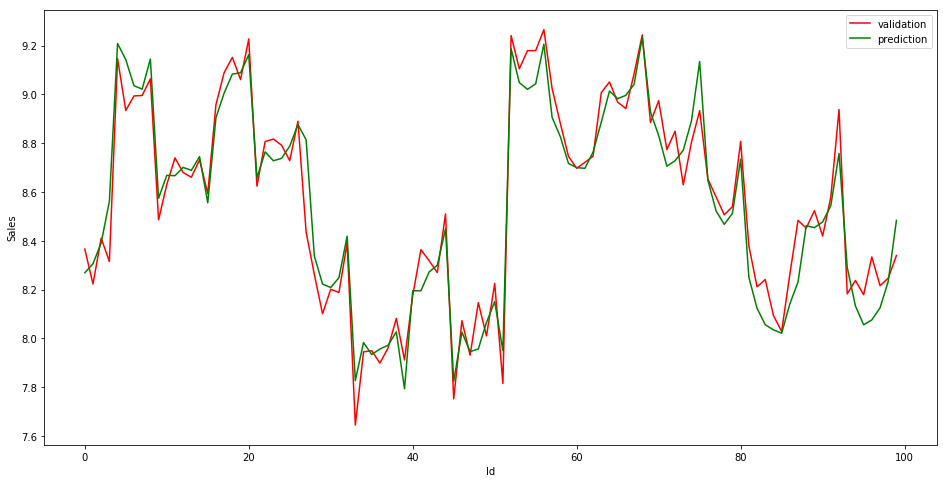

In [48]:
x=range(100)
plt.figure(figsize=(16,8))
plt.plot(x,y_valid[1100:1200], color='red', label='validation')
plt.plot(x,y_pred[1100:1200], color='green', label='prediction')
plt.legend()
plt.xlabel('Id')
plt.ylabel('Sales')
plt.show()

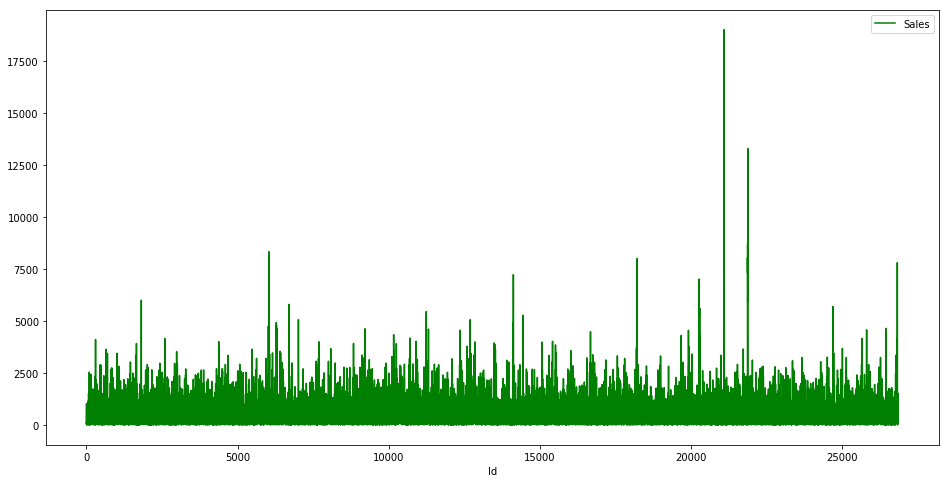

In [65]:
#绝对预测误差
x=range(26845)
plt.figure(figsize=(16,8))
plt.plot(x,abs(np.expm1(y_pred) - np.expm1(y_valid)), color='Green')
plt.legend()
plt.xlabel('Id')
#plt.ylabel('Sales')
plt.show()

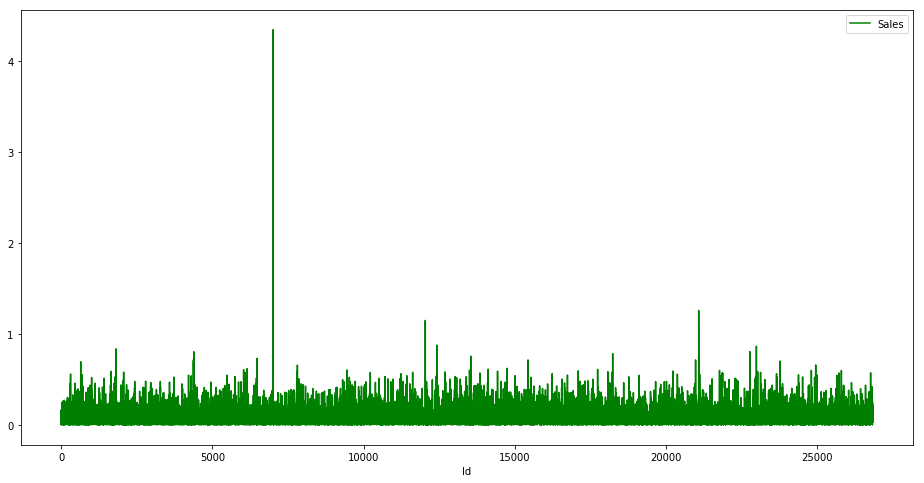

In [66]:
#相对对预测误差
x=range(26845)
plt.figure(figsize=(16,8))
plt.plot(x,abs(np.expm1(y_pred) - np.expm1(y_valid))/np.expm1(y_valid), color='Green')
plt.legend()
plt.xlabel('Id')
#plt.ylabel('Sales')
plt.show()

Best weight is 0.995, RMSPE is 0.1504


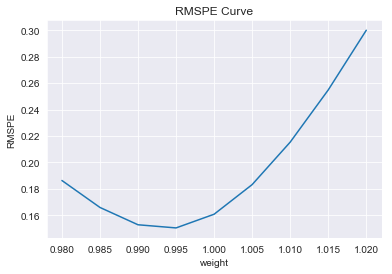

In [71]:
# rmspe修正
def correction():
    weights = np.arange(0.98, 1.02, 0.005)
    errors = []
    for w in weights:
        error = rmspe(np.expm1(y_valid), np.expm1(y_pred*w))
        errors.append(error)
        
    # make line plot
    plt.plot(weights, errors)
    plt.xlabel('weight')
    plt.ylabel('RMSPE')
    plt.title('RMSPE Curve')
    # print min error
    idx = errors.index(min(errors))
    print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors)))
    
correction()

In [72]:
x_train_total.head().append(x_train_total.tail())

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
0,1,5,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,31,31,82.0,24187.75,0
1,1,4,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,30,31,82.0,24187.75,0
2,1,3,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,29,31,82.0,24187.75,0
3,1,2,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,28,31,82.0,24187.75,0
4,1,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,27,31,82.0,24187.75,0
1017202,1115,1,1,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,7,2,24157.0,7.00,0
1017204,1115,6,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,5,1,24157.0,6.75,0
1017205,1115,5,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,4,1,24157.0,6.75,0
1017206,1115,4,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,3,1,24157.0,6.75,0
1017207,1115,3,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,2,1,24157.0,6.75,0


In [73]:
print(x_train_total.shape)
print(y_train_total.shape)

(844338, 20)
(844338,)


In [74]:
dtrain = xgb.DMatrix(x_train_total, y_train_total)
dtest = xgb.DMatrix(x_test)
# specify parameters via map
params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.03,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 10   # Random number seed
          }
num_round = 3000
model = xgb.train(params, dtrain, num_round, verbose_eval=True)
# make prediction
preds = model.predict(dtest)

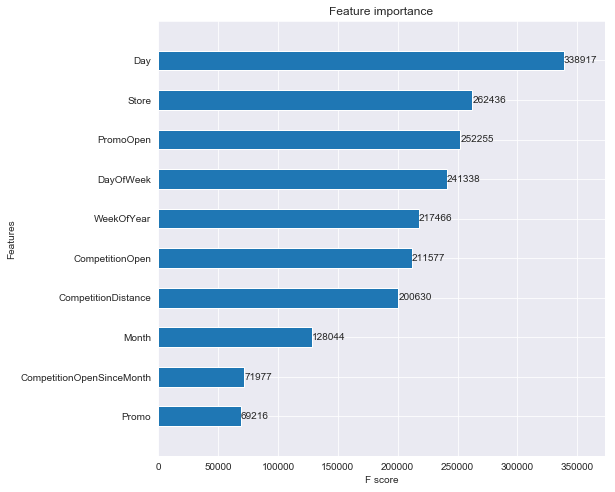

In [75]:
# make submission using best weight
result = pd.DataFrame({"Id": test["Id"],'Sales': np.expm1(preds*0.995)})
result.to_csv("submission_xgb.csv", index=False)

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model, max_num_features= 10, height=0.5, ax=ax)
plt.show()